In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Load MNIST data

In [2]:
mnist_train = torchvision.datasets.MNIST(root='data',train=True,download=True)
mnist_test = torchvision.datasets.MNIST(root='data',train=False,download=True)

#### ODE practice

ODE: $ y' - y = -\frac{1}{2}e^{\frac{t}{2}}\text{sin}(5t)+5e^{\frac{t}{2}}\text{cos}(5t),~y(0)=0$

Solution to ODE: $y(t) = e^{\frac{t}{2}}\text{sin}(5t)$

In [3]:
# Compute actual solution
t = np.linspace(start=0,stop=5, num=10000)
y = np.exp(t/2)*np.sin(5*t)

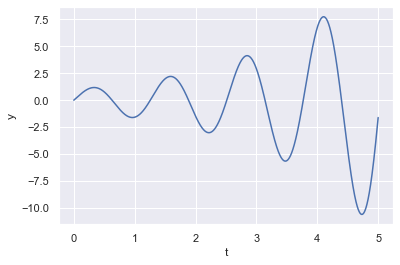

In [4]:
fig,ax=plt.subplots()
ax.plot(t,y)
ax.set_xlabel('t')
ax.set_ylabel('y')
plt.show()

#### Implement Euler's method
Pseudocode: Given initial value $y_0$, initial time $t_0$, step size $h$
- Compute derivative at $t_0$, $\frac{\text{d}y}{\text{d}{t}}\big|_{t=t_0}$
- $y_1 = y_0 + h\frac{\text{d}y}{\text{d}{t}}\big|_{t=t_0}$
- $t_1 = t_0 +h$
- $y_0 = y_1$, $t_0=t_1$

In [3]:
def euler_method(dy_dt, y0, t0, h, n_steps):
    '''Function to compute numerical approximation of ODE. 
    Args: - dy_dt is a function which takes in y,t and represents the derivative
          - y0 and t0 represent the initial value and time, respectively
          - h is the step size (fixed, in this case)
          - n_steps is the number of steps to take'''
    y = [y0]
    t = [t0]
    for _ in range(n_steps):
        m = dy_dt(t0,y0) # compute derivative at t0
        y1 = y0 + h*m # approximate next value
        t1 = t0 + h
        
        y.append(y1) # record values
        t.append(t1)
        
        y0 = y1 # update initial value/time
        t0 = t1
    
    return(t, y)

def rk4(fun, t_span, y0, h):
    '''Runge-Kutta 4th order method
        Args: - fun is derivative
              - t_span is tuple of start and end time
              - y0 is initial condition
              - h is step size (fixed in this case)'''
    weights = torch.tensor([1/6, 1/3, 1/3, 1/6]).view(-1,1)
    n_steps = int((t_span[1]-t_span[0])/h)
    all_y = [y0] # set state to initial state
    all_t = [t_span[0]]
    for _ in range(n_steps):
        y = all_y[-1]
        t = all_t[-1]
        k1 = h * fun(t     , y)
        k2 = h * fun(t+.5*h, y+.5*k1)
        k3 = h * fun(t+.5*h, y+.5*k2)
        k4 = h * fun(t+   h, y+   k3)
        all_y.append(y + torch.sum(weights * torch.cat([k1,k2,k3,k4], dim=0)))
        all_t.append(t + h)
    return(torch.tensor(all_t),torch.tensor(all_y))

def ode1(t,y):
    '''Example differential equation
    Args: y is initial value
          t is time'''
    m = y - (1/2) * np.exp(t/2) * np.sin(5*t) + 5*np.exp(t/2)*np.cos(5*t)
    return m

def ode2(t,y):
    '''Example differential equation
    Args: y is initial value
          t is time'''
    m = y - (1/2) * np.exp(t/2) * np.sin(5*t) + 5*np.exp(t/2)*np.cos(5*t)
    return -m

#### Back to the example:
ODE: $ y' - y = -\frac{1}{2}e^{\frac{t}{2}}\text{sin}(5t)+5e^{\frac{t}{2}}\text{cos}(5t),~y(0)=0$

In [6]:
from scipy.integrate import solve_ivp

# Compute actual solution
t = np.linspace(start=0,stop=5, num=10000)
y = np.exp(t/2)*np.sin(5*t)

# Compute approximate solution
t_hat, y_hat = euler_method(ode1, 0, 0, h=.05, n_steps = 100) # Euler
t_rk , y_rk  = rk4(fun=ode1, y0=torch.tensor([[0.]]), t_span=(0,5), h=.5) # runge-kutta
t_rk2 , y_rk2  = rk4(fun=ode1, y0=torch.tensor([[y_rk[-1]]]), t_span=(5,0), h=-.5) # reverse
res = solve_ivp(fun=ode1, t_span = (0.,5.), y0=np.array([0])) # scipy

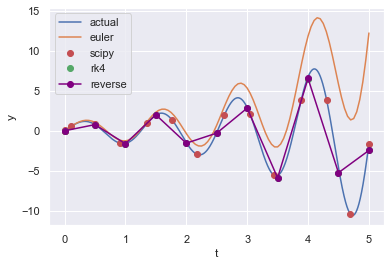

In [7]:
fig,ax=plt.subplots()
ax.plot(t,y, label='actual')
ax.plot(t_hat,y_hat, label='euler')
ax.plot(res.t,res.y.squeeze(0), 'ro', label='scipy')
ax.plot(t_rk.numpy(),y_rk.numpy(), 'go', label='rk4')
ax.plot(t_rk2.numpy(),y_rk2.numpy(), color='purple', marker='o', label='reverse')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend()
fig.savefig('figs/ode_example.png',dpi=150)
plt.show()

ODE: $ y' - y = -\frac{1}{2}e^{\frac{t}{2}}\text{sin}(5t)+5e^{\frac{t}{2}}\text{cos}(5t),~y(0)=0$

#### Adjoint sensitivity method

Want to find: $\frac{dL}{d\theta}$ (derivative of loss with respect to parameters)

First step: find $\frac{\partial L}{\partial \textbf{z}(t)}$

Let $\textbf{a}(t) = \frac{\partial L}{\partial \textbf{z}(t)}$

$\frac{d\textbf{a}(t)}{dt} = -\textbf{a}(t)^\text{T}\frac{\partial f(\textbf{z}(t),t,\theta)}{\partial \textbf{z}}$

Then use the ODE solver to compute $\textbf{a}(t_0) = \frac{\partial L}{\partial \textbf{z}(t_0)}$

To do this, start from the initial value $\textbf{a}(t_1) = \frac{\partial L}{\partial \textbf{z}(t_1)}$

#### Integration practice

<!-- $\int^{t_0+\epsilon}_{t_0}{3x^2}dx = x^3 \big|^{t_0+\epsilon}_{t_0} = (t_0+\epsilon)^3 - t_0^3$ -->

<!-- $\frac{d}{dt}\int^{t_0+\epsilon}_{t_0}{3x^2}dx = \frac{d}{dt}(t_0+\epsilon)^3 - t_0^3 = 3(t_0+\epsilon)^2 - 3t_0^2$ -->


<!-- $\int^{t_0+\epsilon}_{t_0}{f(t)}dt$ -->


<!-- $\int^{t_0+\epsilon}_{t_0}{f(z(t))}dt$ -->

$$f(x) = \int^{x+\epsilon}_{x}{3x^2}dx = \int^{x+\epsilon}_a{3x^2}dx - \int^{x}_a{3x^2}dx$$
Then $\frac{df(x)}{dx} = \frac{d}{dx}\int^{x+\epsilon}_{x}{3x^2}dx = \frac{d}{dx}\int^{x+\epsilon}_a{3x^2}dx - \frac{d}{dx}\int^{x}_a{3x^2}dx = 3(x+\epsilon)^2 - 3x^2$

$$ 3(x+3)^2 - 3x^2 = 3\big((x+3)^2-x^2\big) = 3(x^2+6x+9-x^2)=3(6x+9)=9(2x+3)$$

$$\int^{t+\epsilon}_t f(\textbf{z}(t),t,\theta)dt + \textbf{z}(t) $$

$$\frac{d}{dt}\int^{t+\epsilon}_t f(\textbf{z}(t),t,\theta)dt + \textbf{z}(t) = f(\textbf{z}(t+\epsilon),t+\epsilon,\theta) - f(\textbf{z}(t),t,\theta)$$

In [71]:
# backprop practice
import torch

# Generate data
x = torch.randn(1,2)
W1 = torch.randn(2,3, requires_grad=True)
W2 = torch.randn(3,1, requires_grad=True)
y = torch.randn(1)

# Forward pass
h = x @ W1
y_hat = h @ W2
L = (y-y_hat)**2

L.backward() # backward pass

# Compute gradients manually
dL_dyhat = -2*(y-y_hat)
dyhat_dW2 = h.transpose(0,1)
dL_dW2 = dL_dyhat * dyhat_dW2

dyhat_dh = W2.transpose(0,1)
dh_dW1 = torch.tensor([[x[:,0], 0., 0.,  x[:,1],  0., 0.],
                       [0.  , x[:,0], 0. ,  0., x[:,1], 0.],
                       [0.  ,  0. , x[:,0], 0. ,  0. , x[:,1]]])
dL_dW1 = dL_dyhat * dyhat_dh @ dh_dW1
dL_dW1 = dL_dW1.view(W1.shape)

In [72]:
print(dL_dW1)
print(W1.grad)
print()
print(dL_dW2)
print(W2.grad)

tensor([[-0.6838, -1.6719,  0.0716],
        [-0.4910, -1.2005,  0.0514]], grad_fn=<ViewBackward>)
tensor([[-0.6838, -1.6719,  0.0716],
        [-0.4910, -1.2005,  0.0514]])

tensor([[-1.4021],
        [ 0.1738],
        [ 0.1192]], grad_fn=<MulBackward0>)
tensor([[-1.4021],
        [ 0.1738],
        [ 0.1192]])


#### Adjoint method practice

Define simple network with Runge-Kutta solver, and use adjoint to backpropagate through

In [78]:
import torch
z1 = torch.randn(1)
A = torch.randn(1, requires_grad=True)
B = torch.randn(1, requires_grad=True)

z2 = z1*A
z3 = z2*A
L = (z3-B)**2
L.backward()

print(4*z1*A*(z1*A**2 - B))
print(A.grad)

tensor([-1.3845], grad_fn=<MulBackward0>)
tensor([-1.3845])


In [3]:
def sig(x):
    return(torch.exp(x) / (torch.exp(x) + 1))
def sig_grad(x):
    return (torch.exp(x) * (torch.exp(x) + 1) - torch.exp(2*x)) / (torch.exp(x)+1)**2

x = torch.randn(1, requires_grad=True)
y = sig(x)
y.backward()

print(x.grad)
print(sig_grad(x))

tensor([0.2019])
tensor([0.2019], grad_fn=<DivBackward0>)


In [154]:
x = torch.randn(2)
W = torch.randn(2,2,requires_grad=True)
y = torch.randn(2)

yhat = x@W
L = torch.sum(yhat)
L.backward()

In [159]:
# print(W.grad)
grad_f = torch.tensor([[[x[0],0],[x[1],0]],[[0,x[0]],[0,x[1]]]])
grad_L = (torch.tensor([[1.,1.]]) @ grad_f.view(grad_f.shape[0],-1)).view(2,2)

print(grad_f)
print(grad_f.view(grad_f.shape[0],-1))
print()
print(grad_L)
print()
print(W.grad)

tensor([[[-2.1595,  0.0000],
         [ 1.9961,  0.0000]],

        [[ 0.0000, -2.1595],
         [ 0.0000,  1.9961]]])
tensor([[-2.1595,  0.0000,  1.9961,  0.0000],
        [ 0.0000, -2.1595,  0.0000,  1.9961]])

tensor([[-2.1595, -2.1595],
        [ 1.9961,  1.9961]])

None


In [160]:
print(torch.stack([torch.cat([x.view(2,1), torch.zeros(2,1)], dim=1),
             torch.cat([torch.zeros(2,1), x.view(2,1)], dim=1)], dim=0))
print(torch.stack([torch.cat([x.view(2,1), torch.zeros(2,1)], dim=1),
             torch.cat([torch.zeros(2,1), x.view(2,1)], dim=1)], dim=0)[:,:1,:])

tensor([[[-2.1595,  0.0000],
         [ 1.9961,  0.0000]],

        [[ 0.0000, -2.1595],
         [ 0.0000,  1.9961]]])
tensor([[[-2.1595,  0.0000]],

        [[ 0.0000, -2.1595]]])


# Residual block

In [46]:
x = torch.randn(2)
W = torch.randn(2,2,requires_grad=True)
y = torch.randn(2)

yhat = sig(x@W) + x
L = torch.sum((yhat-y)**2) / 2
L.backward()

In [47]:
# Compute partial derivatives manually
dL_dyhat = yhat-y
dsig_dz = sig_grad(x@W)
dz_dW = torch.stack([torch.cat([x.view(2,1), torch.zeros(2,1)], dim=1),
             torch.cat([torch.zeros(2,1), x.view(2,1)], dim=1)], dim=0)
# Gradient of loss with respect to W
grad = (dL_dyhat @ (dsig_dz.view(-1,1,1) * dz_dW).view(dL_dyhat.shape[-1], -1)).view(W.shape)

In [50]:
print('Manually computed gradient:')
print(grad)

print('\nTorch gradient:')
print(W.grad)

Manually computed gradient:
tensor([[0.4135, 0.2827],
        [0.2311, 0.1580]], grad_fn=<ViewBackward>)

Torch gradient:
tensor([[0.4135, 0.2827],
        [0.2311, 0.1580]])


#### Try to compute gradient using adjoint method for simple ODE

In [82]:
A = torch.randn(1, requires_grad=True)
x = torch.randn(1, requires_grad=True)
def f(x): return A*x + x
yhat = f(f(f(x)))

yhat.backward()
print(A.grad)
print(2*f(x))

print()
print(x.grad)
print((A+1)**2)

tensor([-1.5325])
tensor([-0.8330], grad_fn=<MulBackward0>)

tensor([1.8453])
tensor([1.5044], grad_fn=<PowBackward0>)


In [103]:
def f(x): return A*x

A = torch.randn(1, requires_grad=True)
x = torch.randn(1, requires_grad=True)
yhat = f(f(x))

yhat.backward()

print(A.grad)
print(2*A*x)


tensor([-0.7406])
tensor([-0.7406], grad_fn=<MulBackward0>)


#### Vector-jacobian product example

In [29]:
# Vector-jacobian product ("vjp")
W = torch.tensor([[1.,2.],[3.,4.]])
b = 3
x = torch.tensor([[5.],[7.]], requires_grad=True)
a = torch.tensor([[-1.],[2.]])
y = W @ x + b

y.backward(a) # get VJP: vector is a, jacobian is dy/dx

print(x.grad)

tensor([[5.],
        [6.]])


### Implement adjoint method and compare to regular

In [105]:
import torch.nn as nn
import torch.nn.functional as F

class mini_net(nn.Module):
    
    def __init__(self, W=torch.randn(1, requires_grad=True)):
        super(mini_net, self).__init__()
        self.W = W
        
    def f(self, t, y):
        # This is dz/dt (change in hidden state with respect to time)
        return(sig(self.W * y))
    
def sig(x):
    return(torch.exp(x) / (torch.exp(x) + 1))

# Def function for backward pass
def ode_vjp(fun, a, z, t):
    # Compute vector-jacobian product (vjp) of a(t) and df/dz
    # fun is function of z (hidden state) and t (time)
    out = fun(t, z) # forward pass
    out.backward(a) # compute vjp
    return(z.grad)

def ode_torch(t,y):
    '''Example differential equation
    Args: y is initial value
          t is time'''
    t = torch.tensor(t)
    m = y - 1/2 * torch.exp(t/2) * torch.sin(5*t) + 5*torch.exp(t/2)*torch.cos(5*t)
    return m

def rk_adjoint(fun, t_span, y0, h):
    '''Runge-Kutta 4th order method
        Args: - fun is derivative
              - t_span is tuple of start and end time
              - y0 is initial condition
              - h is step size (fixed in this case)'''
    w = torch.tensor([1/6, 1/3, 1/3, 1/6]) # weights
    w = w.expand(*y0.shape,4).permute(2,0,1)
    n_steps = int((t_span[1]-t_span[0])/h)
    y = y0 # set state to initial state
    t = t_span[0]
    all_y = [y0] # set state to initial state
    all_t = [t_span[0]]
    for _ in range(n_steps):
        k1 = h * fun(t     , y)
        k2 = h * fun(t+.5*h, y+.5*k1)
        k3 = h * fun(t+.5*h, y+.5*k2)
        k4 = h * fun(t+   h, y+   k3)
        t = t + h
        y = y + torch.sum(w*torch.stack([k1,k2,k3,k4],dim=0), dim=0)
        all_y.append(y)
        all_t.append(t)
    return torch.stack(all_y,dim=0), torch.tensor(all_t)

# Augmented dynamics: function applied to concatenation of hidden state and adjoint state
def aug_dynamics(t, aug_state, fun=ode_torch):
    ''' function is wrapper for ode_vjp
    Args: t is time
          aug_state is tensor concatenation [a,z], i.e. adjoint state and hidden state
          fun is function used to evaluate ode_vjp
    Returns: derivatives of adjoint and hidden state (respectively) with respect to time
                i.e. torch.concat([da/dt, dz/dt])'''
    len_z = int(len(aug_state)/2)
    a = aug_state[:1,:].detach()
    z = aug_state[1:,:].detach().clone().requires_grad_(True)
    return torch.cat([ode_vjp(fun, a, z, t), fun(t,z)], dim=0)

### Apply adjoint method

In [129]:
torch.manual_seed(0)
y = torch.randn(1) # ground truth

# Parameters for Runge-Kutta
t_span = [0.,5.]
h = .5

# Forward pass
y_forward, t_forward = rk_adjoint(fun=ode_torch, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].requires_grad_(True)
L = torch.mean((y-z1)**2) # compute loss
L.backward() # compute adjoint at t = t_1

# Backward pass (using adjoint)
y,t = rk_adjoint(fun=aug_dynamics, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)

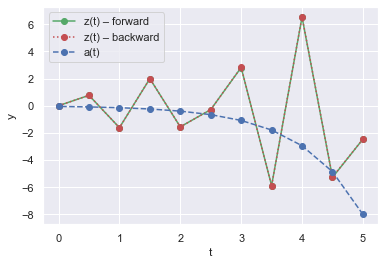

In [130]:
fig,ax=plt.subplots()
ax.plot(t_forward.numpy(),y_forward[:,0,0].numpy(), label='z(t) – forward', color='g',marker='o', linestyle='-')
ax.plot(t.numpy(),y[:,1,0].detach().numpy(), label='z(t) – backward', color='r',marker='o', linestyle=':')
ax.plot(t.numpy(),y[:,0,0].detach().numpy(), label='a(t)', marker='o', linestyle='--')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend()
plt.show()